In [ ]:
# Yahoo Finance

import yfinance as yf
import pandas as pd
from datetime import date
import os
from glob import glob

now = date.today().isoformat()

assets = [
    # QQQ
    'QQQ',
    'QLD', # 2x long
    'TQQQ', # 3x long
    'PSQ', # 1x short
    'QID', # 2x short
    'SQQQ', # 3x short

    # IWM
    'IWM',
    'UWM', # 2x long
    'TNA', # 3x long
    'RWM', # 1x short
    'TWM', # 2x short
    'TZA', # 3x short

    # SPX
    'SPY',
    'SSO', # 2x long
    'UPRO', # 3x long
    'SH', # 1x short
    'SDS', # 2x short
    'SPXU', # 3x short
]

for s in assets:
    if len(glob(f'fundamental/{s.lower()}-????-??-??.parquet')) > 0:
        print(f'skipping {s.lower()}')
        continue

    df = yf.download(s, period='max',interval='1d',multi_level_index=False,auto_adjust=True)

    df.reset_index(inplace=True)
    df.rename(columns={
        'Open':'open',
        'High':'high',
        'Low':'low',
        'Close':'close',
        'Volume':'volume',
        'Date':'timestamp'},inplace=True)
    
    # index by date
    df.timestamp = pd.to_datetime(df.timestamp)
    df.set_index('timestamp', inplace=True)
    df.sort_index(inplace=True)
    
    p = os.path.join('fundamental',f'{s.lower()}-{now}.parquet')
    df.to_parquet(p, engine='pyarrow', compression='zstd')
    

In [3]:
# momentum signals

import functools as fc
import itertools as it
import pandas as pd
import numpy as np
import warnings
import os

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

src = "fundamental/qqq-2025-11-14.parquet"
dst = "derived/qqq-2025-11-14-mom-signals.parquet"

df = pd.read_parquet(src)
df['absret'] = df.open - df.shift(1).open

windows = list(range(1,30)) + list(range(30,100,5)) + list(range(100,500,10))

# compute sma
for w in windows:
    sma = df.open.rolling(w, min_periods=1).mean()    
    df[f'sma{w}'] = sma.where(sma.notna(), df.open)

# compute ema
for w in windows:
    ema = df.open.ewm(span=w, adjust=False).mean()    
    df[f'ema{w}'] = ema.where(ema.notna(), df.open)

df = df.copy()

# compute rsi
for w in windows:
    up = df.absret.where(df.absret > 0.0, 0).ewm(com=w - 1,adjust=False,min_periods=w).mean()
    down = df.absret.where(df.absret < 0.0, 0).ewm(com=w - 1,adjust=False,min_periods=w).mean()
    rsi = 100 - (100 / (1 + (up / (-1 * down))))
    
    edge = lambda a,b: 1 if a < 50 and b > 50 else -1 if a > 70 and b < 70 else 0
    df[f'rsi{w}'] = rsi.rolling(2,min_periods=2).apply(lambda r: edge(r.iloc[0], r.iloc[1])) \
                       .replace(0.0,np.nan).ffill()

# open and sma/ema
for w in windows:
    df[f'open_sma{w}'] = df.open - df[f'sma{w}']
    df[f'open_ema{w}'] = df.open - df[f'ema{w}']

# fast and slow sma/ema
for [fast, slow] in filter(lambda w: w[0] < w[1], it.product(windows, windows)):
    df[f'sma{fast}_{slow}'] = df[f'sma{fast}'] - df[f'sma{slow}']
    df[f'ema{fast}_{slow}'] = df[f'ema{fast}'] - df[f'ema{slow}']
    df[f'emasma{fast}_{slow}'] = df[f'ema{fast}'] - df[f'sma{slow}']

df.to_parquet(dst, engine='pyarrow', compression='zstd')

In [63]:
# signal returns

import functools as fc
import itertools as it
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from tqdm import tqdm
import warnings


warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

src = 'qqq-2025-11-14-mom-signals.parquet'
dst_win = 'qqq-2025-11-14-mom-win-returns.parquet'
dst_cum = 'qqq-2025-11-14-mom-cum-returns.parquet'

df = pd.read_parquet(os.path.join('derived',src))
signals = list(filter(lambda c: re.match(r'^(open_.+)|(.ma\d+_.+)|(rsi.+)|(emasma.+)$', c), df.columns.values))

periods = [220, 1100, 2200]
eodret = np.log(df.open / df.shift(1).open).shift(-1).fillna(0)

# rolling window returns
rwin = pd.DataFrame(np.nan,index=df.index.copy(),
                   columns=list(map(
                       lambda s: f'benchmark_{s[1]}_{s[0]//220}y',
                       it.product(periods, ['sd','avg']))))


for period in periods:
    win = eodret.rolling(period)
    y = period // 220
    rwin[f'benchmark_sd_{y}y'] = win.std()
    rwin[f'benchmark_avg_{y}y'] = win.mean()

# full returns
rcum = pd.DataFrame(np.nan, index=signals, columns=('ret','sd','avg'))
rcum.loc['benchmark'] = [eodret.sum(), eodret.std(), eodret.mean()]

for s in tqdm(signals):
    perf = eodret.where(df[s] > 0, 0)
    
    rcum.loc[s] = [perf.sum(), perf.std(), perf.mean()]

    for period in periods:
        win = perf.rolling(period)
        y = period // 220
        bench = rwin[f'benchmark_avg_{y}y']
        
        ir = (win.mean() - bench) / win.std()
        # if the whole window's return is 0, ir is inf. fix that
        ir[np.isinf(ir)] = 0
        rwin[f'{s}_ir_{y}y'] = ir


rcum['ir'] = np.nan_to_num((rcum.avg - rcum.loc['benchmark'].avg) / rcum.sd)
rcum.sort_values(['ir'],inplace=True, ascending=False)

rwin.to_parquet(os.path.join('derived',dst_win), engine='pyarrow', compression='zstd')
rcum.to_parquet(os.path.join('derived',dst_cum), engine='pyarrow', compression='zstd')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10458/10458 [02:02<00:00, 85.17it/s]


In [152]:
import pandas as pd
import numpy as np
import functools as fc
import itertools as it
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from tqdm import tqdm
import warnings

rwin = pd.read_parquet('derived/qqq-2025-11-14-mom-win-returns.parquet')
rcum = pd.read_parquet('derived/qqq-2025-11-14-mom-cum-returns.parquet')
df = pd.read_parquet('fundamental/qqq-2025-11-14.parquet')

In [189]:
src_cols = list(filter(lambda c: '_ir_' in c, rwin.columns))
dst_cols = list(map(lambda c: f'{c}_rank', src_cols))
rrank = pd.DataFrame(-1, index=rwin.index.copy(), columns=dst_cols)
for i in tqdm(range(0, len(rwin))):
    rrank.iloc[i] = rwin.iloc[i][src_cols].fillna(-np.inf).argsort()

rrank

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6714/6714 [01:08<00:00, 97.63it/s]


,rsi1_ir_1y_rank,rsi1_ir_5y_rank,rsi1_ir_10y_rank,rsi2_ir_1y_rank,rsi2_ir_5y_rank,rsi2_ir_10y_rank,rsi3_ir_1y_rank,rsi3_ir_5y_rank,rsi3_ir_10y_rank,rsi4_ir_1y_rank,...,emasma470_490_ir_10y_rank,sma480_490_ir_1y_rank,sma480_490_ir_5y_rank,sma480_490_ir_10y_rank,ema480_490_ir_1y_rank,ema480_490_ir_5y_rank,ema480_490_ir_10y_rank,emasma480_490_ir_1y_rank,emasma480_490_ir_5y_rank,emasma480_490_ir_10y_rank
timestamp,,,,,,,,,,,,,,,,,,,,,
1999-03-10,0,20922,20921,20920,20919,20918,20917,20916,20915,20914,...,10457,10456,10455,10454,10453,10452,10451,10450,10448,31373
1999-03-11,0,20922,20921,20920,20919,20918,20917,20916,20915,20914,...,10457,10456,10455,10454,10453,10452,10451,10450,10448,31373
1999-03-12,0,20922,20921,20920,20919,20918,20917,20916,20915,20914,...,10457,10456,10455,10454,10453,10452,10451,10450,10448,31373
1999-03-15,0,20922,20921,20920,20919,20918,20917,20916,20915,20914,...,10457,10456,10455,10454,10453,10452,10451,10450,10448,31373
1999-03-16,0,20922,20921,20920,20919,20918,20917,20916,20915,20914,...,10457,10456,10455,10454,10453,10452,10451,10450,10448,31373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-07,30300,29850,29121,261,762,756,2250,28473,12075,30435,...,7167,6528,7797,6537,5880,7806,13281,6543,6534,7137
2025-11-10,30300,29850,29121,762,261,756,28473,30435,2250,29841,...,7167,6528,7797,6537,5880,7806,13281,6543,6534,7137
2025-11-11,30300,29850,29121,762,756,261,28473,30435,2250,29841,...,7167,6528,6537,7797,5880,7806,13281,6543,6534,7137


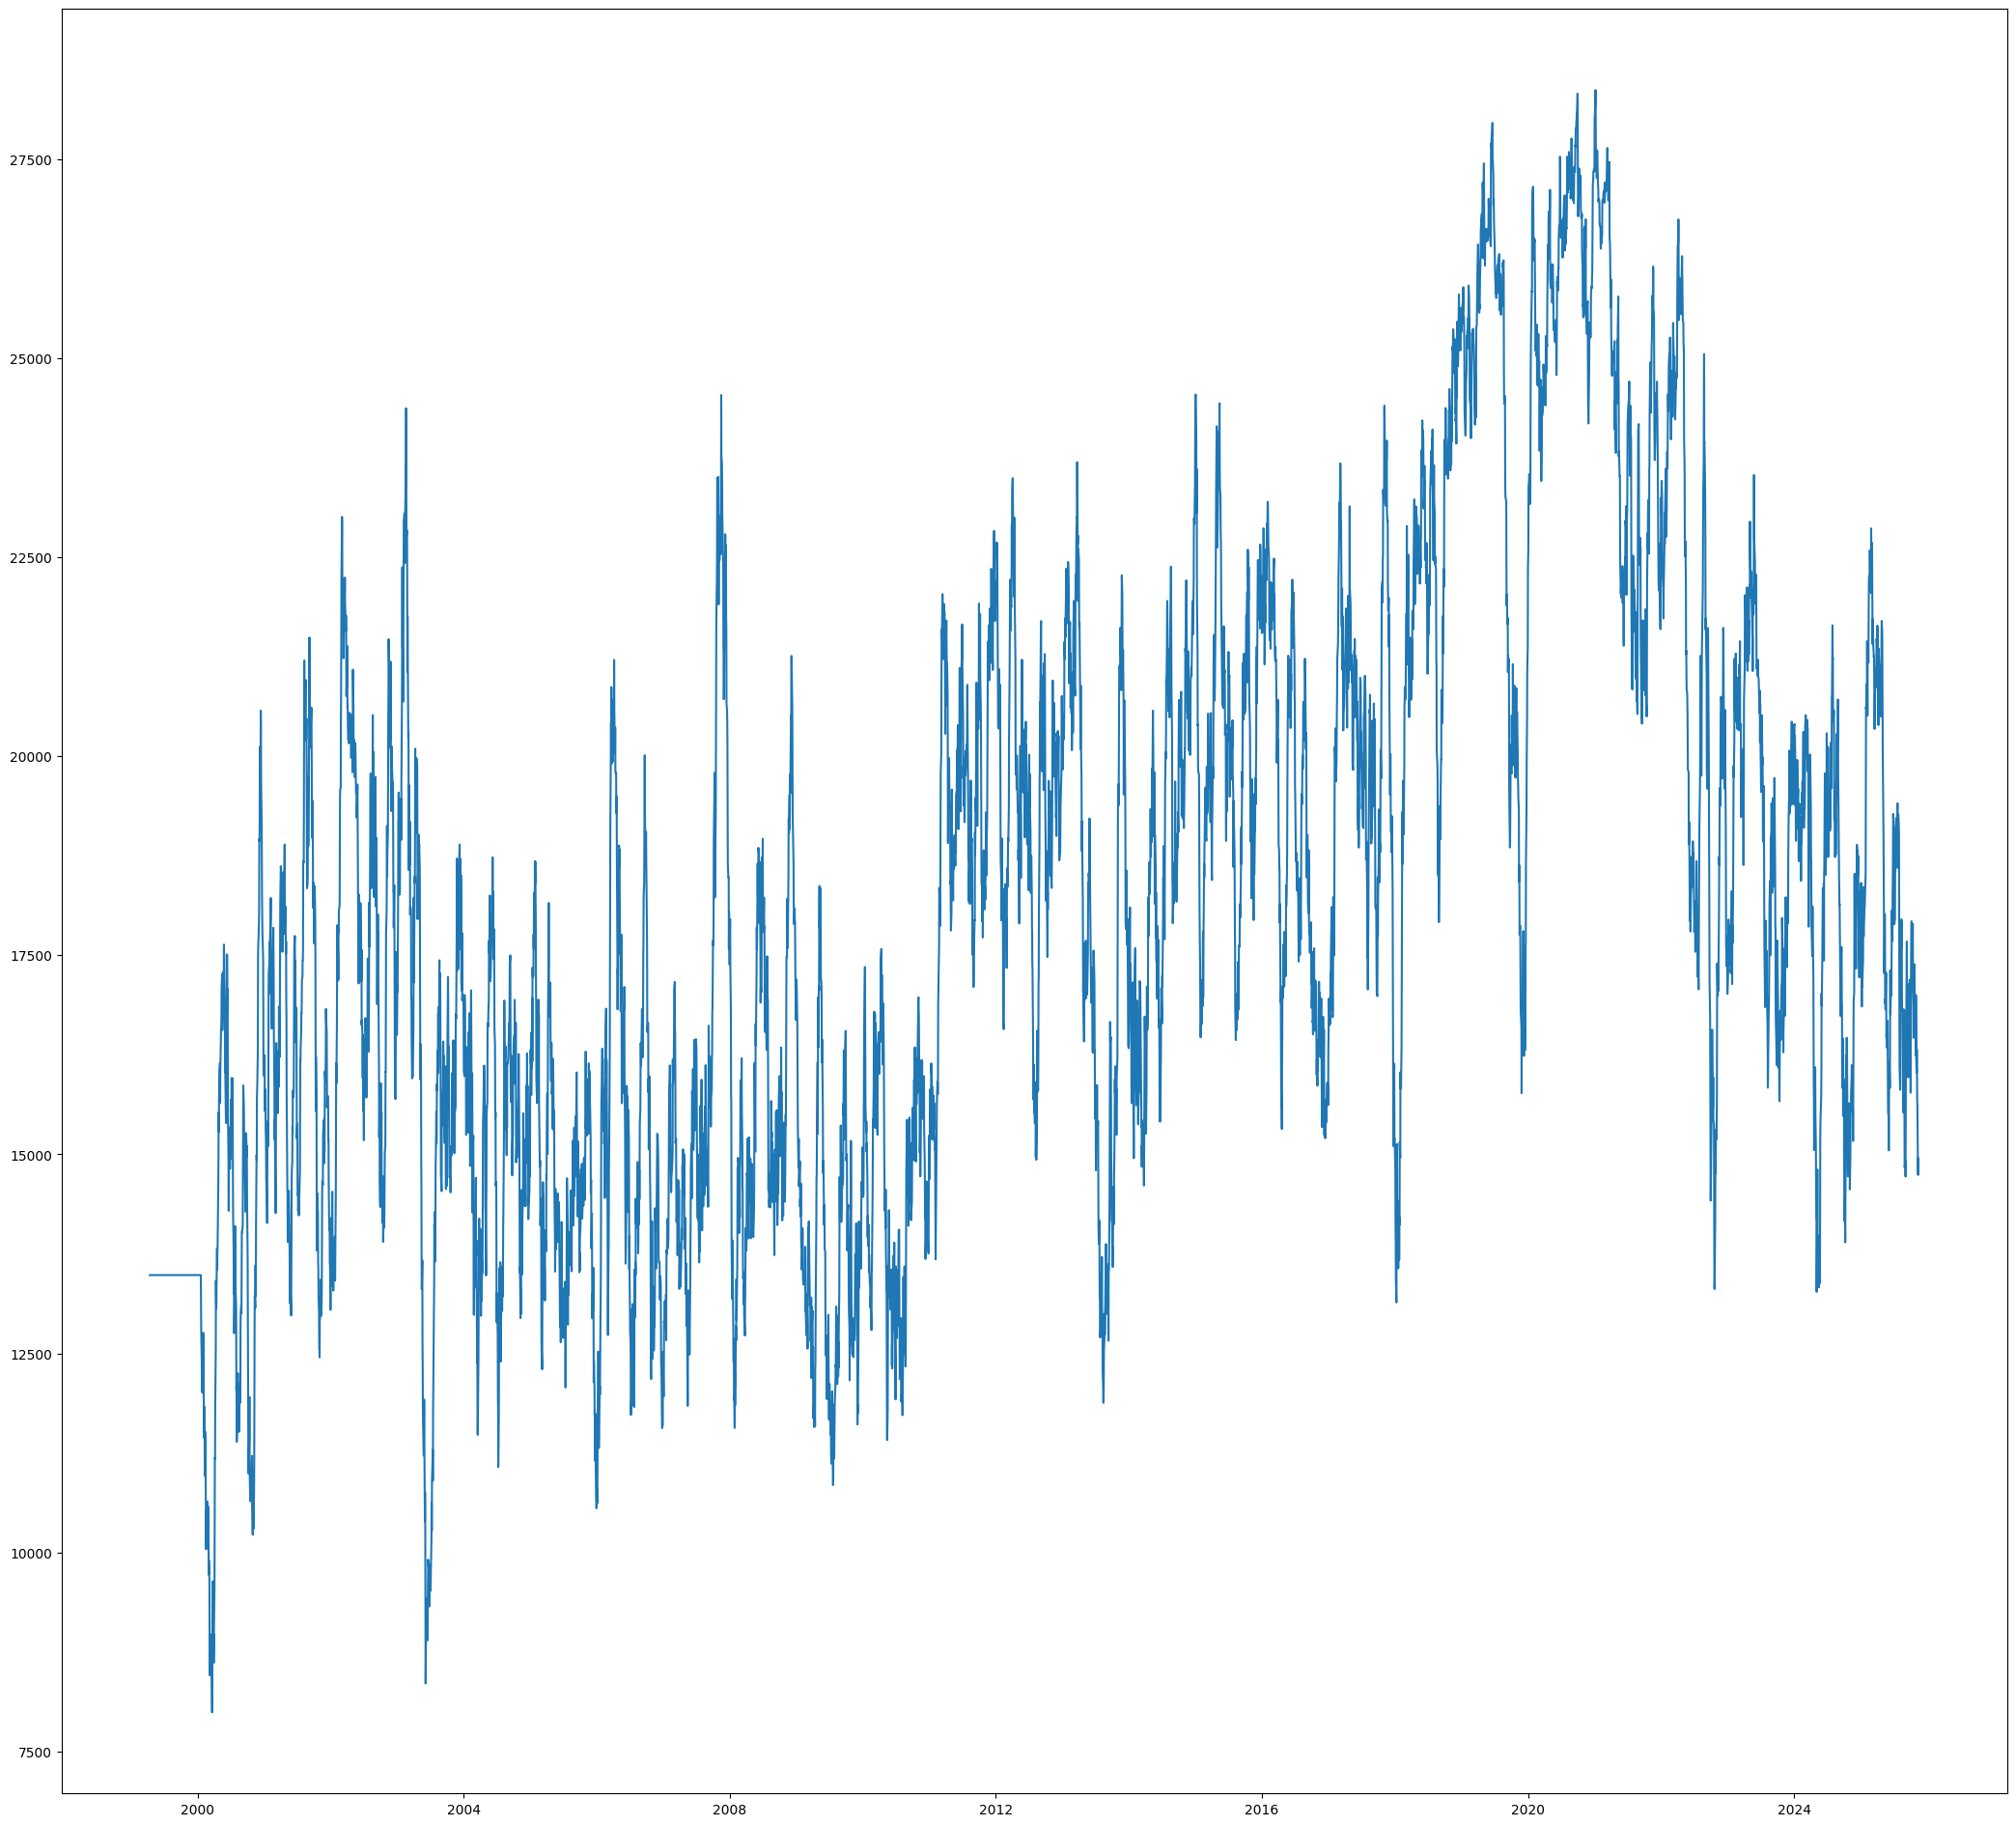

In [190]:
import seaborn as sns
import matplotlib.pylab as plt


cols = list(map(lambda c: f'{c}_ir_1y_rank', rcum.index[:100].to_list()))

fig = plt.figure(figsize=(26,24))
ax = fig.add_subplot(111)
#sns.heatmap(rrank[cols].rolling(5,step=5).mean(),ax=ax)
ax.plot(rrank.index, rrank.emasma95_220_ir_1y_rank.rolling(25).mean())


In [194]:
rrank.iloc[-2].sort_values()

rsi20_ir_1y_rank                 0
sma2_80_ir_5y_rank               1
ema1_27_ir_10y_rank              2
emasma3_13_ir_5y_rank            3
ema14_360_ir_5y_rank             4
                             ...  
ema120_400_ir_1y_rank        31369
emasma160_210_ir_10y_rank    31370
emasma160_210_ir_1y_rank     31371
sma40_95_ir_1y_rank          31372
emasma17_19_ir_10y_rank      31373
Name: 2025-11-12 00:00:00, Length: 31374, dtype: int64

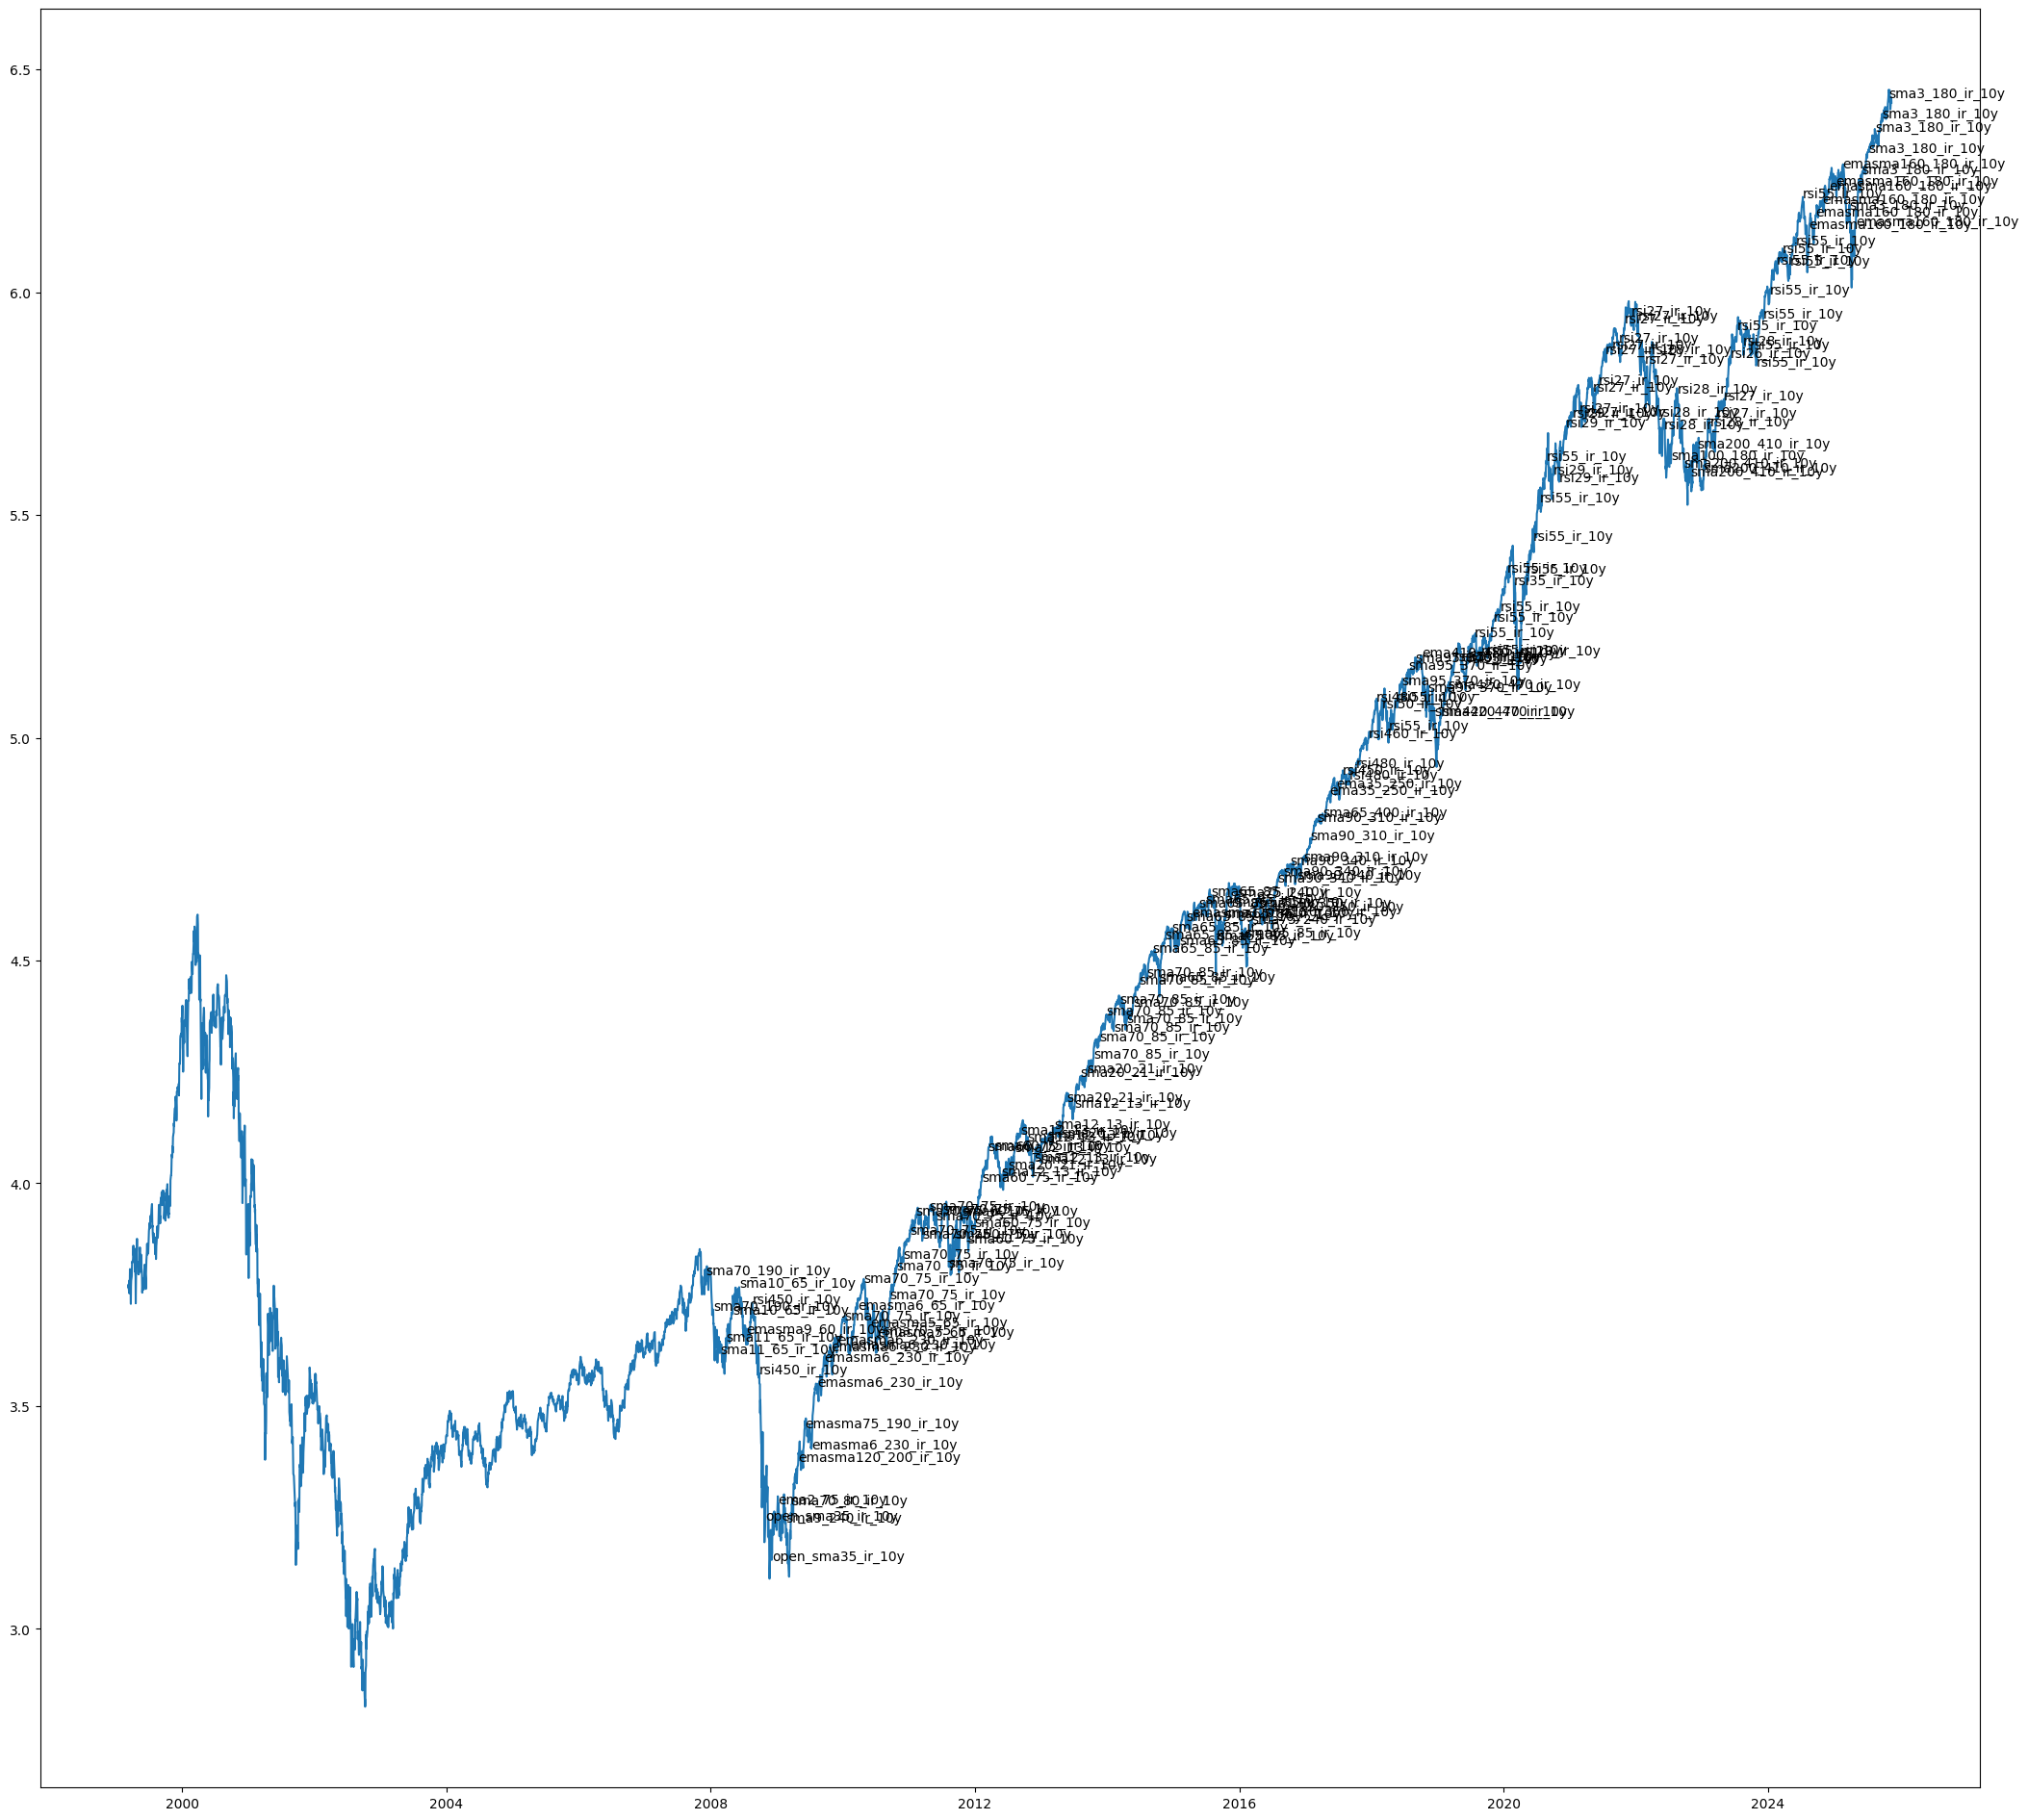

In [120]:
fig = plt.figure(figsize=(26,24))
ax = fig.add_subplot(111)
ax.plot(df.index, np.log(df.open))

# timeline for each signal: postition in the n best signals

for i in range(0, len(df), 25):
    row = df.iloc[i]
    ts = df.index[i]
    ir = rwin.loc[ts][row['10y']]
    if ir <= 0 or np.isnan(ir):
        continue
    ax.annotate(row['10y'],xy=(ts, np.log(row.open)))

plt.show()

/Users/kai/studies/.venv/lib/python3.13/site-packages/matplotlib/colors.py:2295: RuntimeWarning: overflow encountered in divide
  resdat /= (vmax - vmin)
/Users/kai/studies/.venv/lib/python3.13/site-packages/matplotlib/colors.py:2295: RuntimeWarning: overflow encountered in divide
  resdat /= (vmax - vmin)
/Users/kai/studies/.venv/lib/python3.13/site-packages/matplotlib/colors.py:2295: RuntimeWarning: overflow encountered in divide
  resdat /= (vmax - vmin)


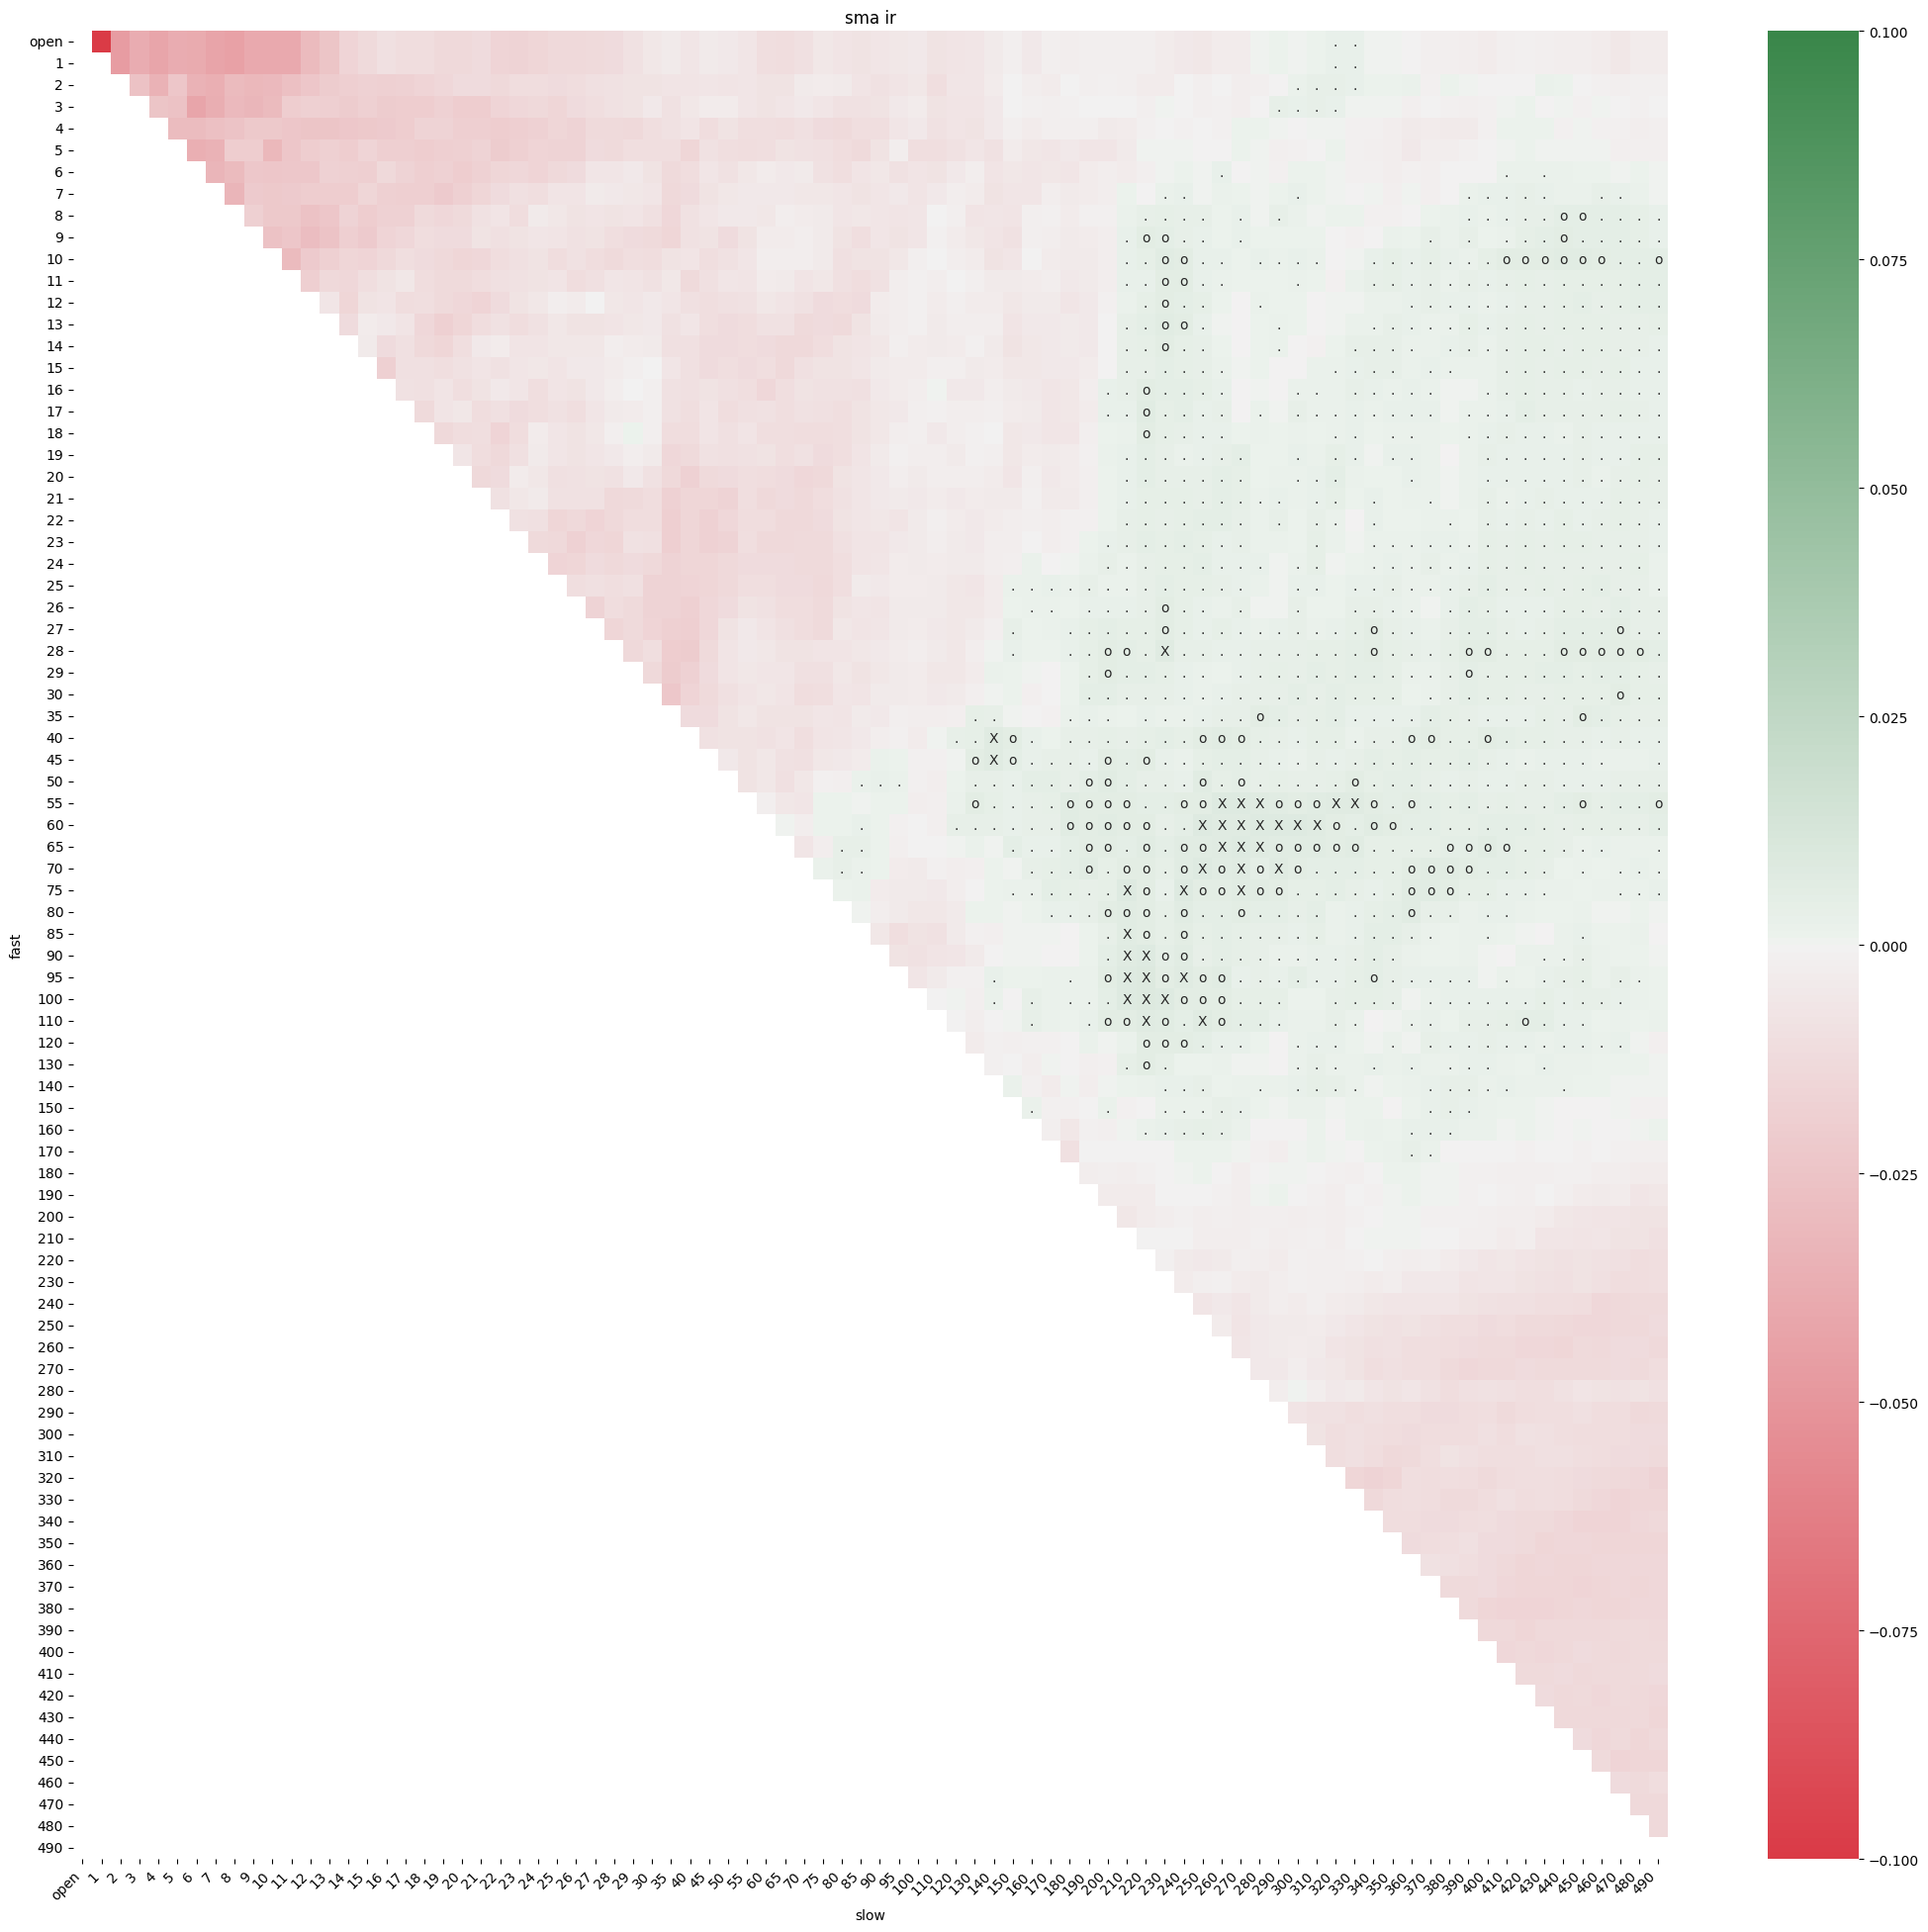

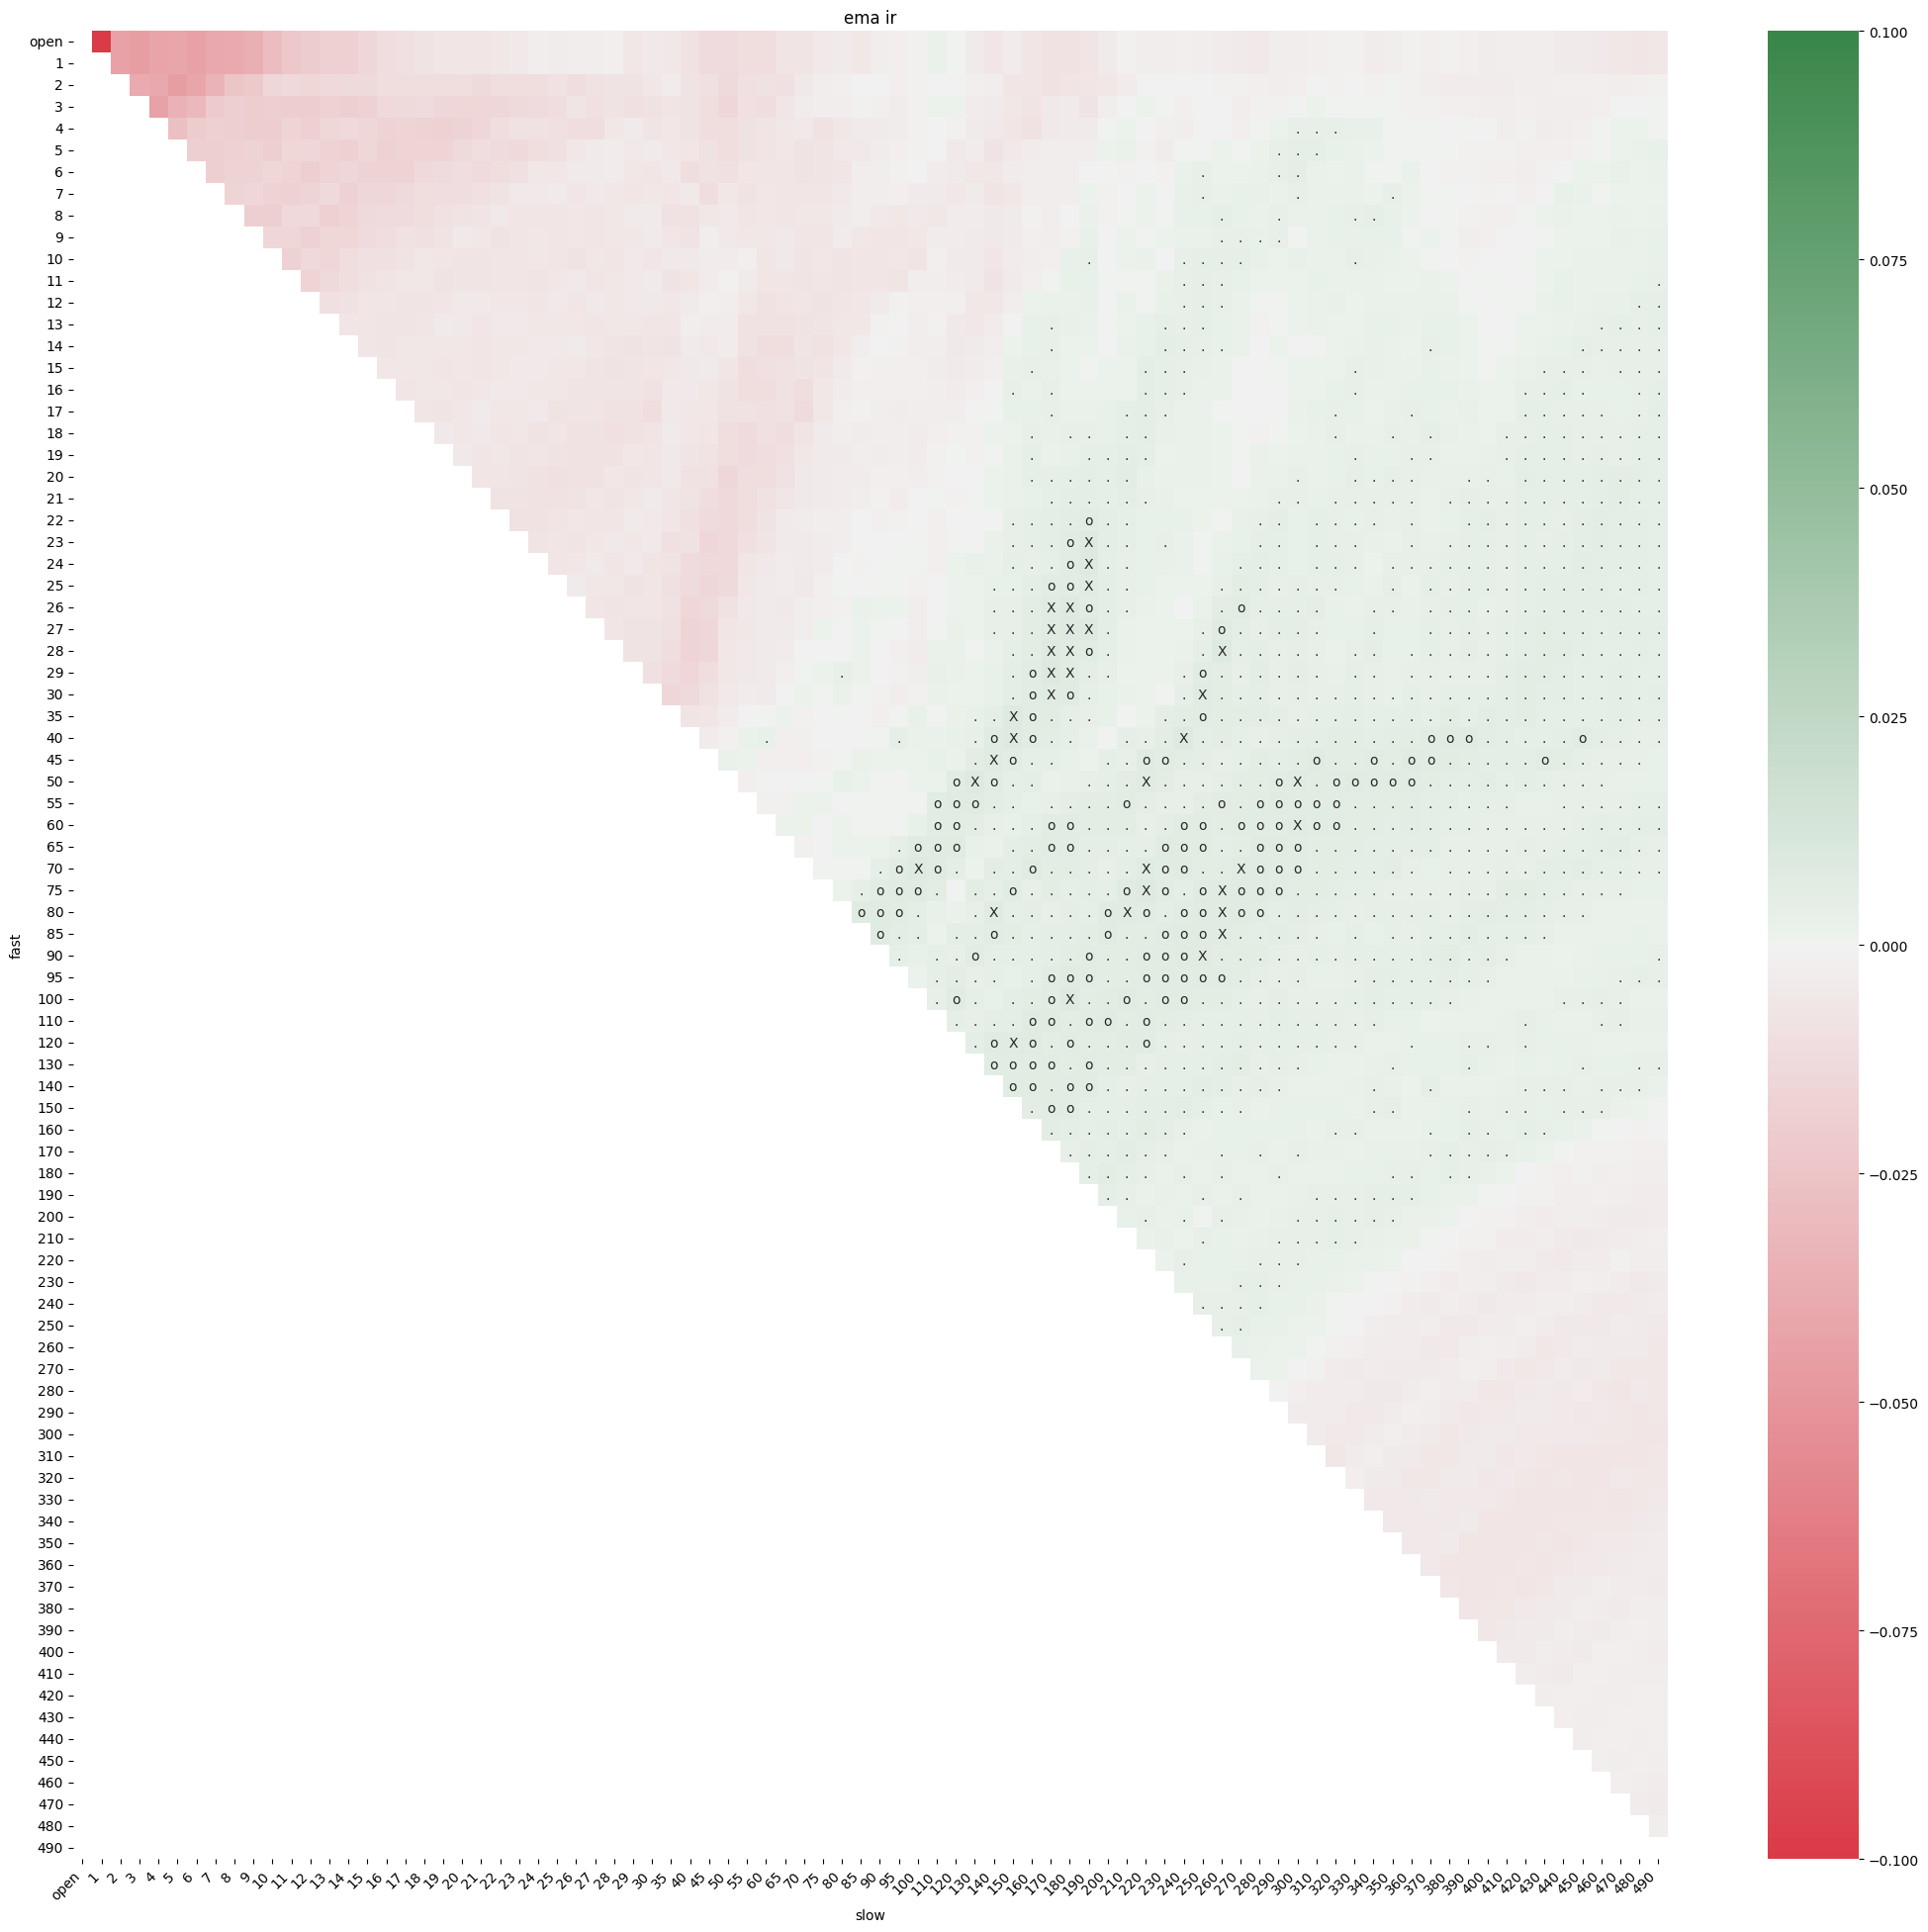

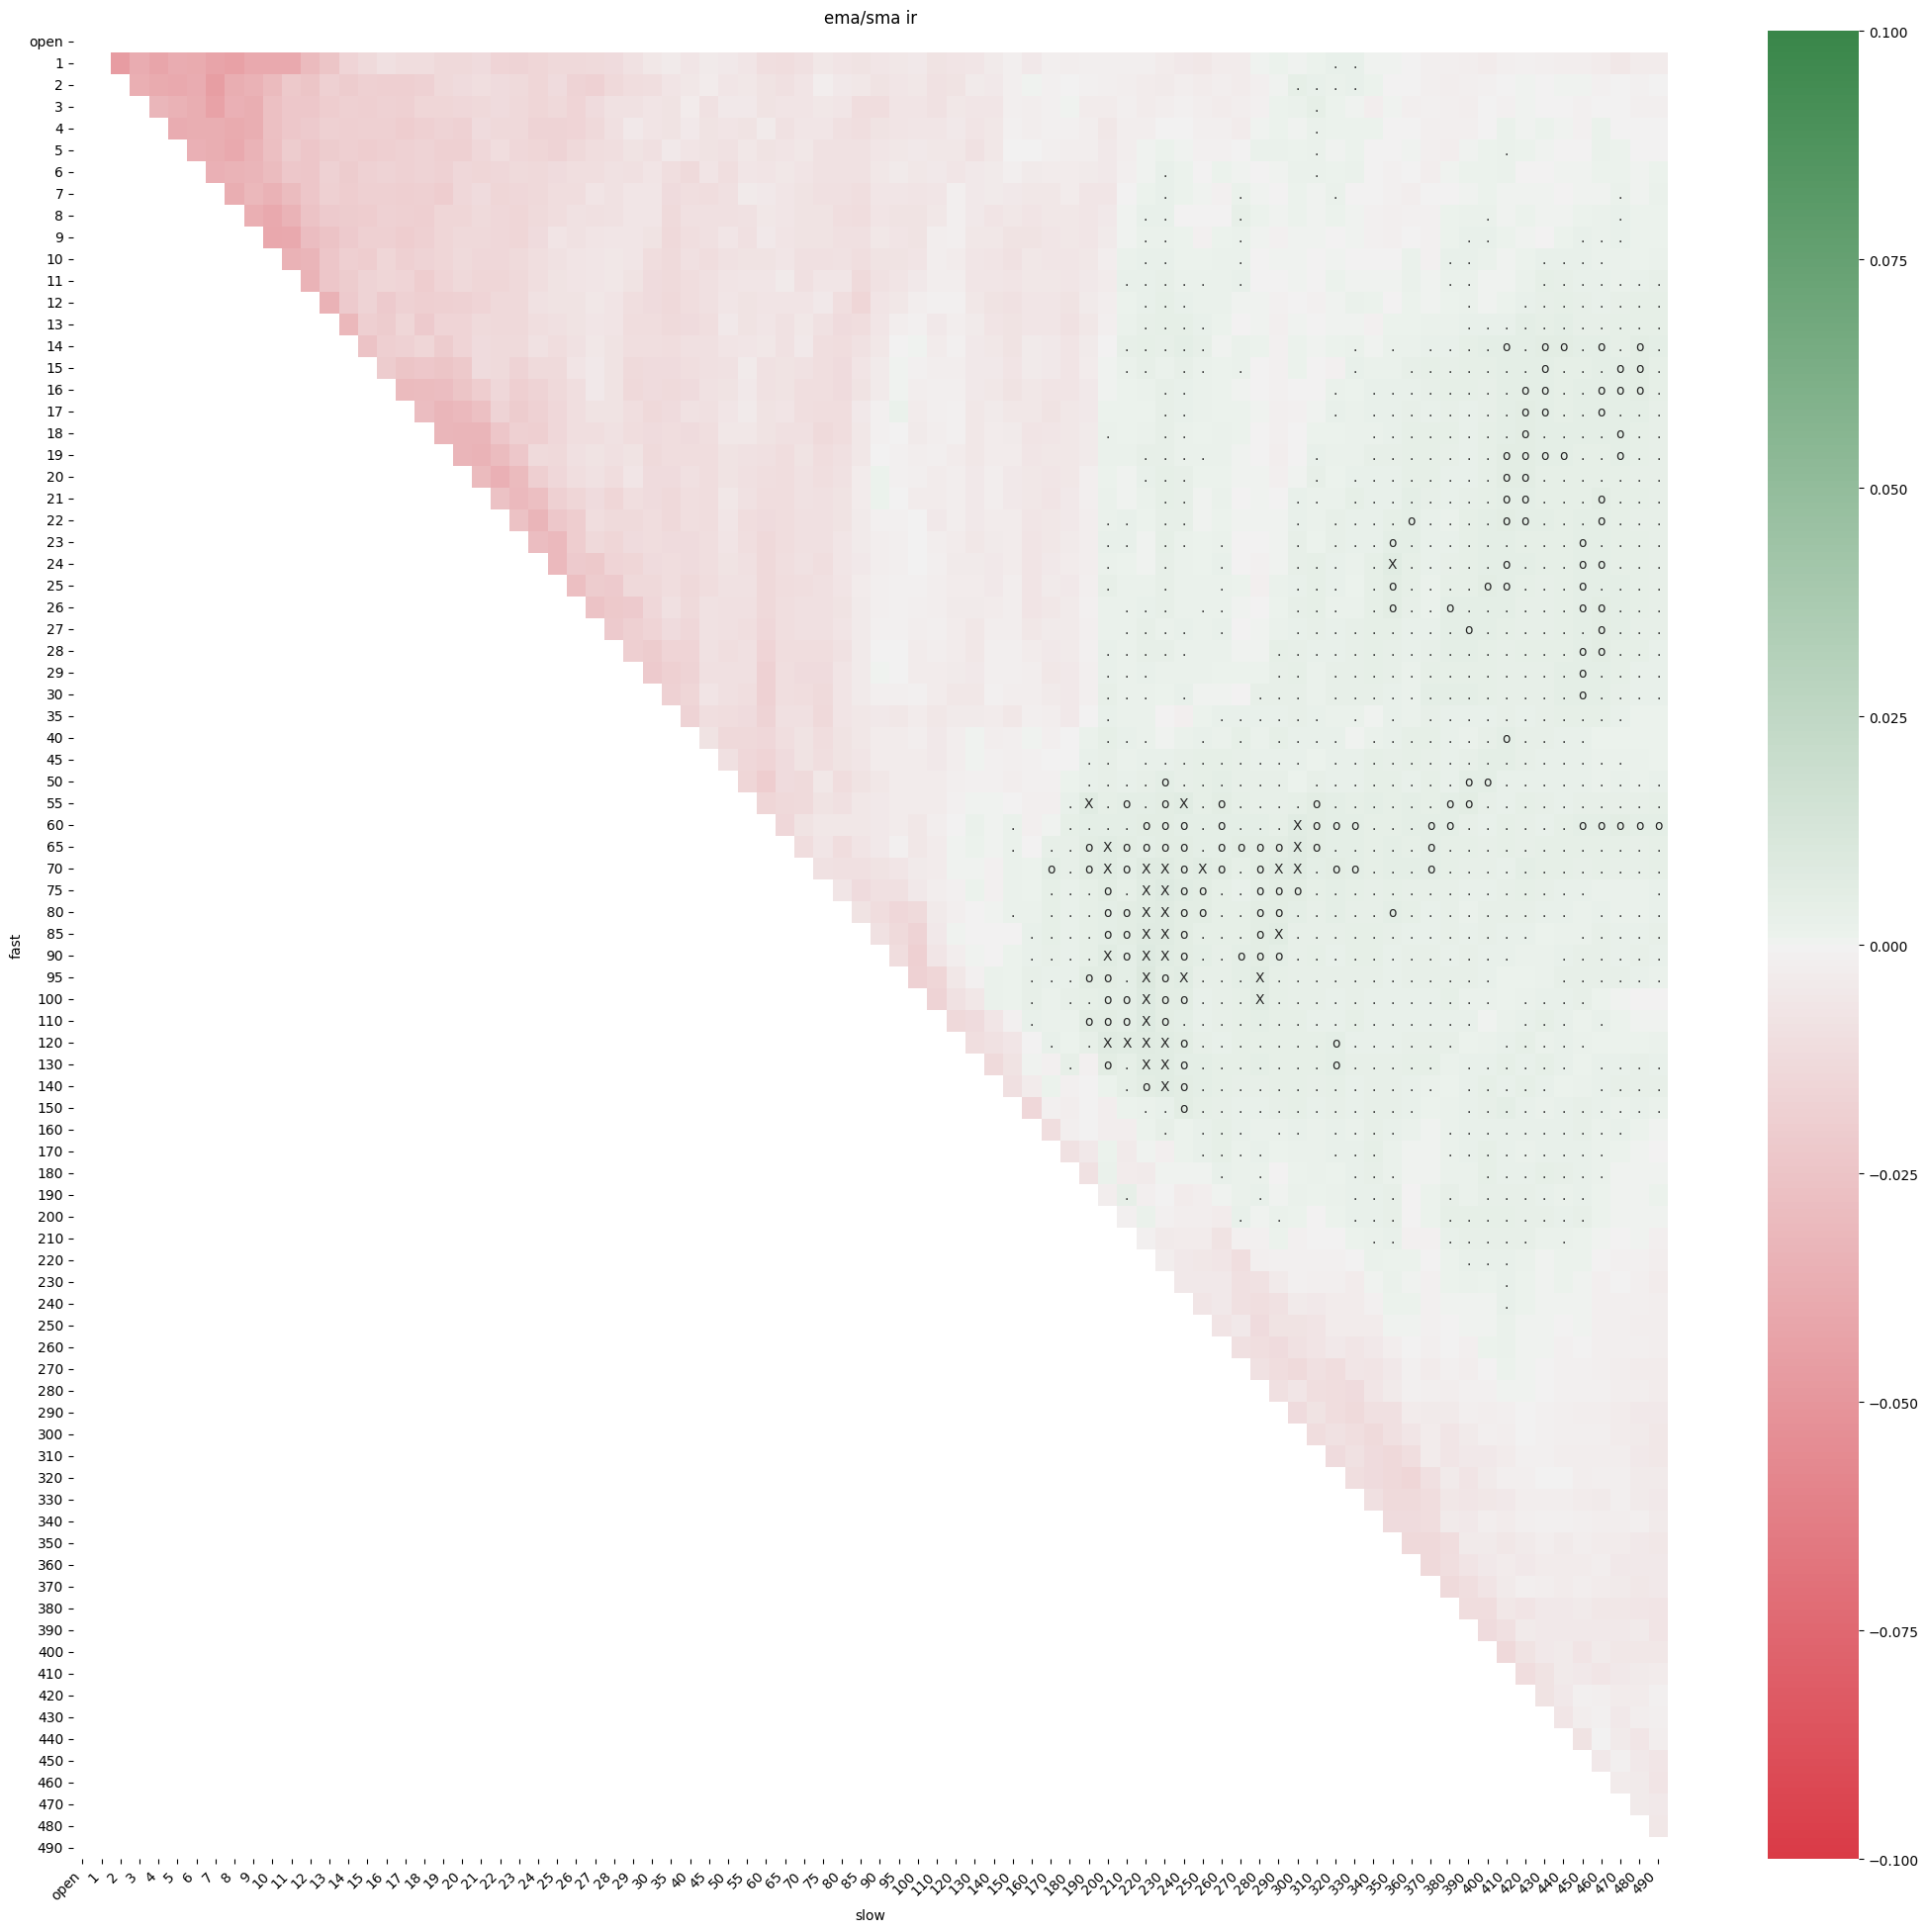

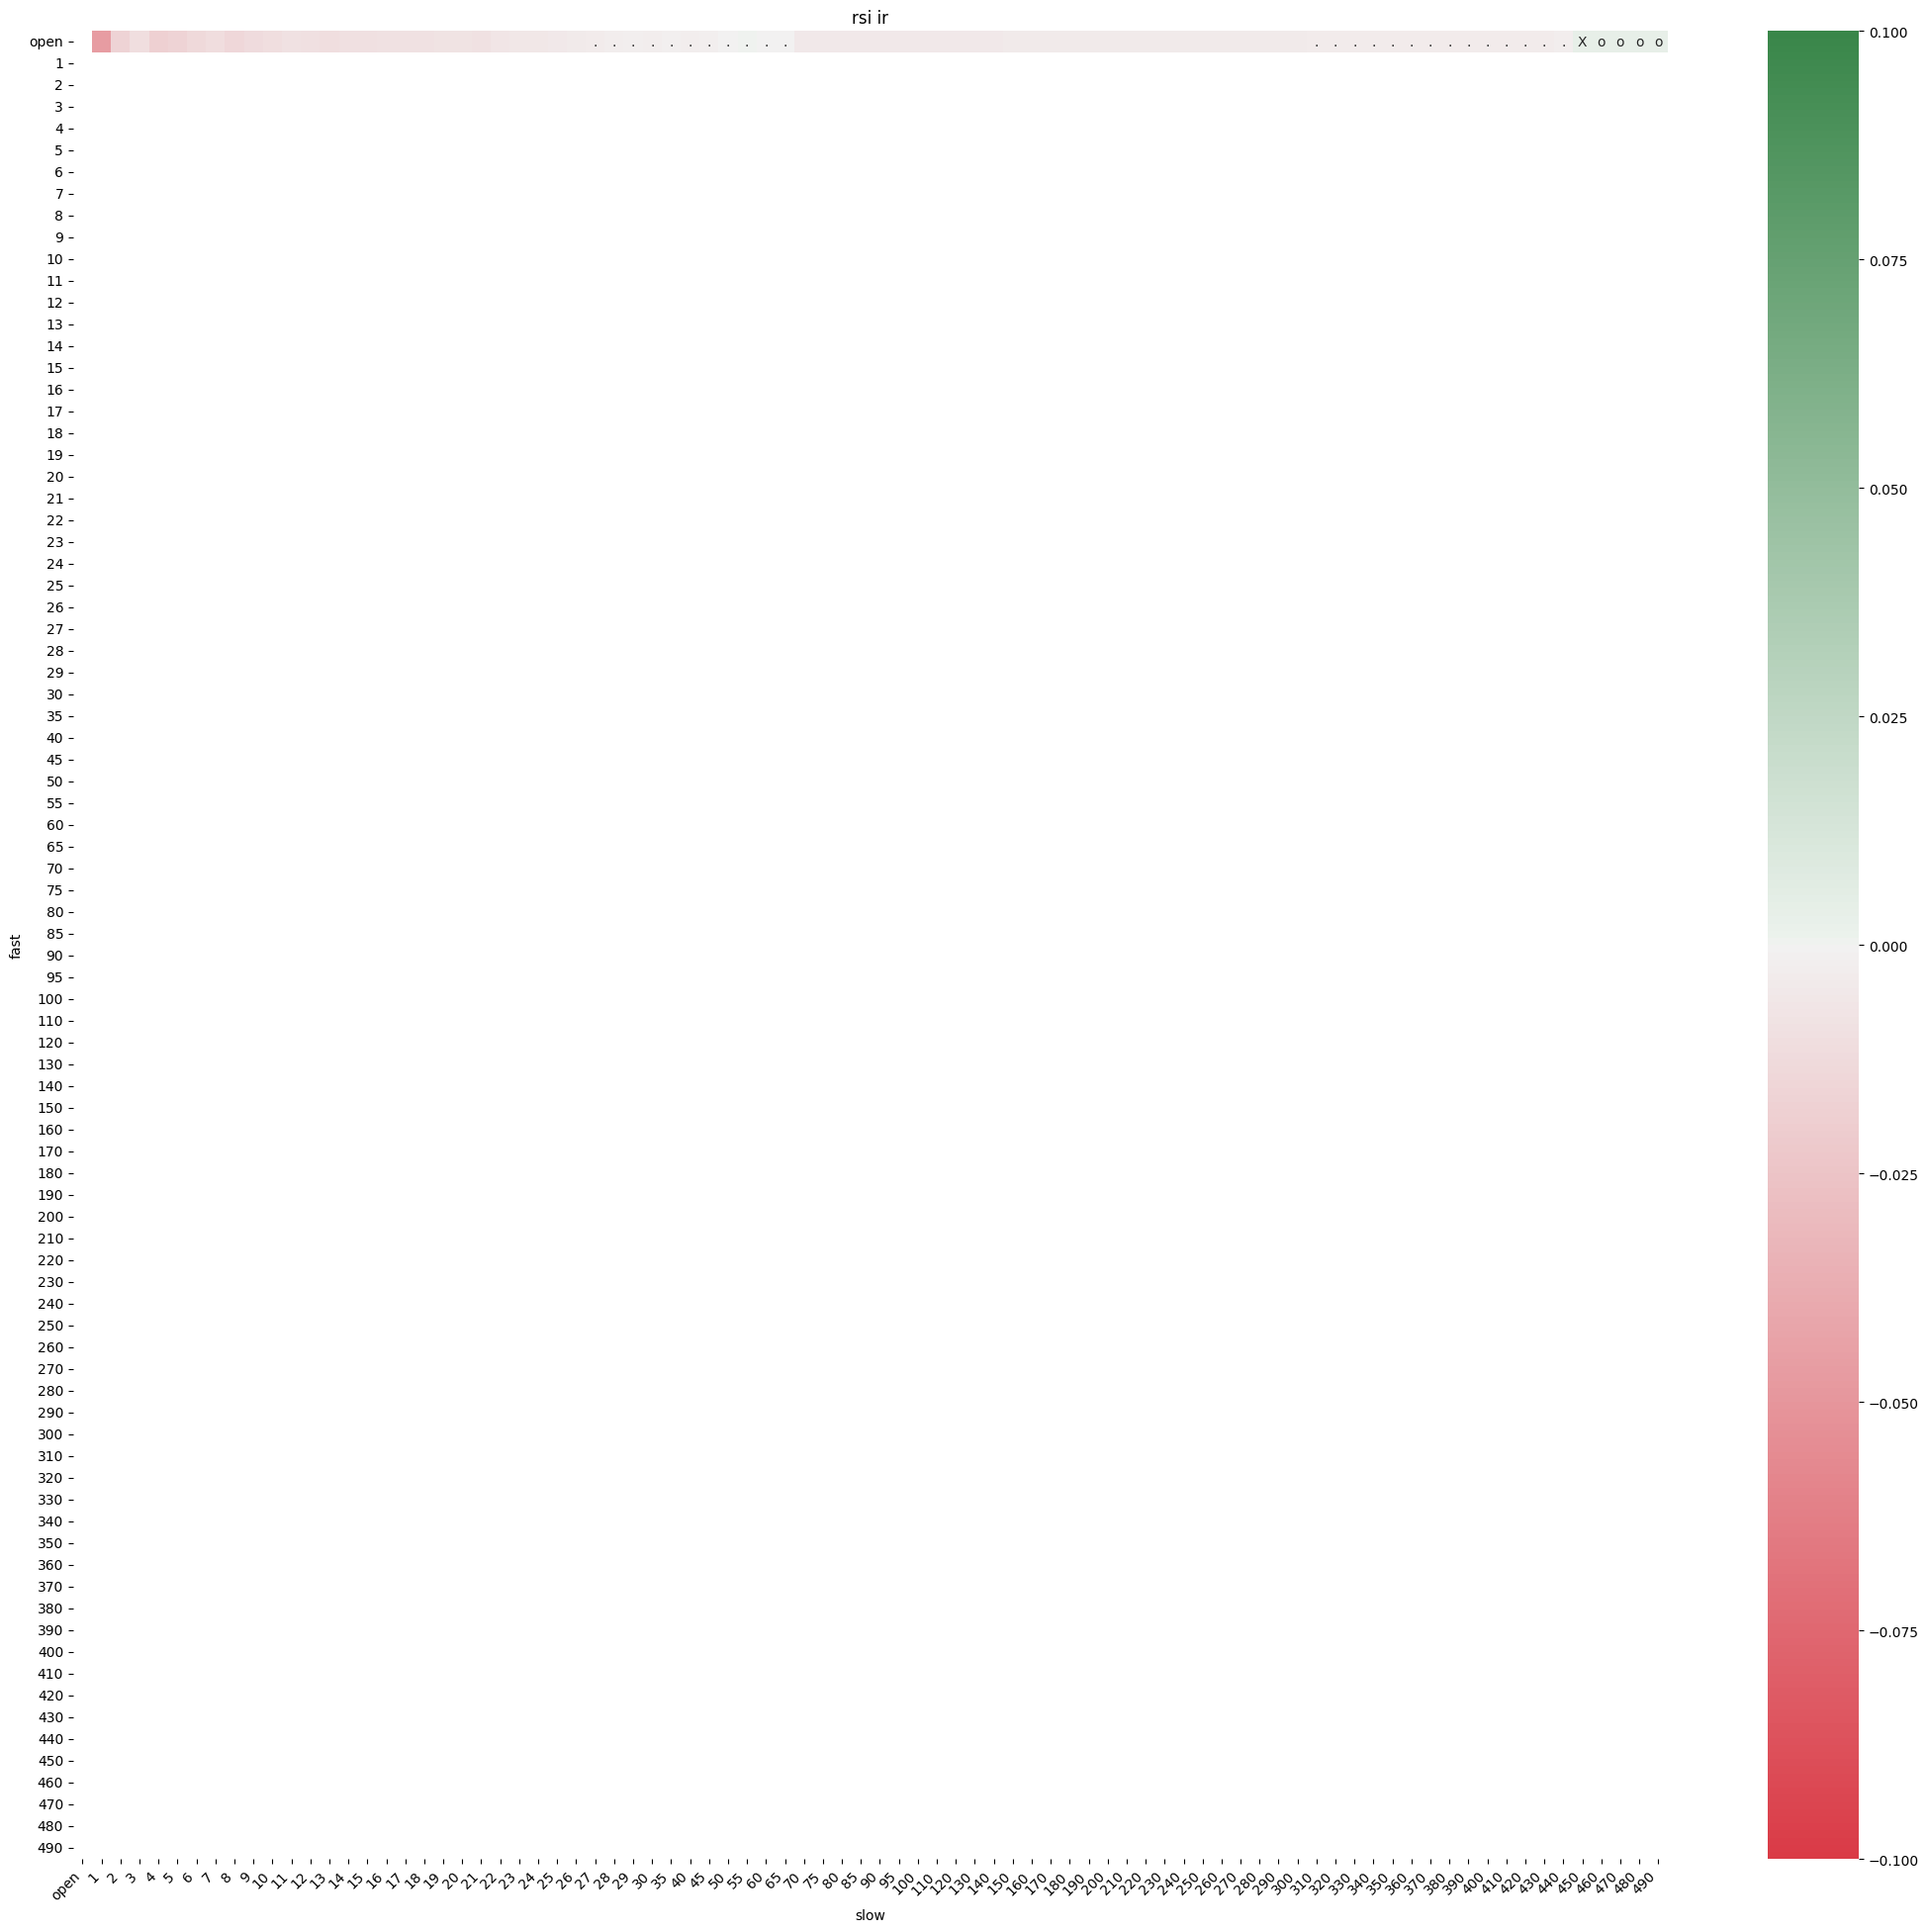

In [26]:
# hyperparameter heatmaps

import seaborn as sns
import matplotlib.pylab as plt

windows = list(range(1,30)) + list(range(30,100,5)) + list(range(100,500,10))


# fast / slow
sma_ir = np.full((len(windows) + 1, len(windows) + 1), np.nan)
ema_ir = np.full((len(windows) + 1, len(windows) + 1), np.nan)
rsi_ir = np.full((len(windows) + 1, len(windows) + 1), np.nan)
mix_ir = np.full((len(windows) + 1, len(windows) + 1), np.nan)

ew = list(enumerate(windows,start=1))
for [i,w] in ew:
    sma_ir[0,i] = rwin.loc[f'open_sma{w}'].ir
    ema_ir[0,i] = rwin.loc[f'open_ema{w}'].ir
    rsi_ir[0,i] = rwin.loc[f'rsi{w}'].ir
    
for [[i,fast], [j,slow]] in filter(lambda w: w[0][1] < w[1][1], it.product(ew,ew)):
    sma_ir[i,j] = rwin.loc[f'sma{fast}_{slow}'].ir
    ema_ir[i,j] = rwin.loc[f'ema{fast}_{slow}'].ir
    mix_ir[i,j] = rwin.loc[f'emasma{fast}_{slow}'].ir

cm = sns.diverging_palette(h_neg=10, h_pos=133, s=75, l=50, as_cmap=True)

for [nam, arr] in [['sma',sma_ir],['ema',ema_ir],['ema/sma',mix_ir],['rsi',rsi_ir]]:
    fig = plt.figure(figsize=(26,24))
    ax = fig.add_subplot(111)

    [p68,p95,p99] = np.nanpercentile(arr, [68,95,99])

    sns.heatmap(
        arr,
        ax=ax,
        mask=np.isnan(arr),
        vmin=np.min(arr),
        vmax=np.max(arr),
        annot=np.where(arr >= p99, 'X', np.where(arr >= p95, 'o', np.where(arr >= p68, '.', ''))),
        fmt='s',
        cmap=cm)
    
    ax.set_yticklabels(['open'] + windows, rotation=0)
    ax.set_xticklabels(['open'] + windows, rotation=45, ha='right')
    ax.set(ylabel="fast", xlabel="slow")
    ax.set_title(f'{nam} ir')
        
    
plt.show()

In [ ]:
lookfwd = 60 # trading days
runs = []
active = None
for date in df.index:
    go_long = df.long_signal[date]
    go_short = df.short_signal[date]
    
    if active == None:
        if go_long:
            active = date
        continue
    if not go_short and len(df.open[active:date]) <= lookfwd:
        continue

    entry = df.open[active]
    run = df.open[active:date].apply(lambda x: x/entry).values[1:]
    runs.append(np.pad(run, (0,lookfwd-len(run)), mode='constant',constant_values=np.nan))
    active = None


signal = pd.DataFrame(
    {
        'std': np.nanstd(runs,axis=0),
        'mean': np.nanmean(runs,axis=0),
        'min': np.nanmin(runs,axis=0),
        'max': np.nanmax(runs,axis=0),
    } + np.quartile(runs,[.25,.5,.75],axis=0
    columns=['std','mean','min','max'],
    index=range(lookfwd))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

open_segs = np.column_stack((range(len(df.open)), np.log(df.open)))
open_segs = list(zip(open_segs, open_segs[1:]))
color_segs = np.where(df.above_sma, 'green', 'red')

px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, [ax0, ax1] = plt.subplots(nrows=2,figsize=(1500*px, 1000*px))

# price
ax0.set_xlim(0, len(df.open))
ax0.set_ylim(0, np.log(df.open.max()))
ax0.scatter(range(len(df.index)), np.log(df.open.mask(~df.long_signal)), color='black', s=20)
ax0.add_collection(LineCollection(open_segs,colors=color_segs))
ax0.plot(range(len(df.sma)), np.log(df.sma))

# signal returns
ax1.set_xlim(1, lookfwd)
maxabs = max(abs(1-signal['min'].min()), abs(1-signal['max'].max()))
ax1.set_ylim(1-maxabs, 1+maxabs)

ax1.plot(range(1, lookfwd+1), np.ones(lookfwd), color='red')
# 1 sigma error bars
ax1.errorbar(range(1, lookfwd+1), signal['mean'], yerr=signal['std']*2)
plt.show()